In [1]:
from nilearn import datasets 
#fetching msdl atlas 
msdl_atlas = datasets.fetch_atlas_msdl()
#loading atlas image stored in 'maps'
atlas_filename = msdl_atlas['maps']
#loading atlas data stored in 'labels'
labels = msdl_atlas['labels']


from nilearn.input_data import NiftiMapsMasker
#introducing mask which forms time series from fmri data 
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize = True, verbose =5)

C:\Users\katia\AppData\Roaming\Python\Python38\site-packages\nilearn\datasets\__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
C:\Users\katia\anaconda3\lib\site-packages\numpy\lib\npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


sdl_atlas\MSDL_rois\msdl_rois.nii
[NiftiMapsMasker.transform_single_imgs] Loading data from C:\Users\katia\nilearn_data\development_fmri\development_fmri\sub-pixar078_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMapsMasker.fit_transform] loading regions from C:\Users\katia\nilearn_data\msdl_atlas\MSDL_rois\msdl_rois.nii
[NiftiMapsMasker.transform_single_imgs] Loading data from C:\Users\katia\nilearn_data\development_fmri\development_fmri\sub-pixar079_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
[NiftiMapsMasker.fit_transform] loading regions from C:\Users\katia\nilearn_data\msdl_atlas\MSDL_rois\msdl_rois.nii
[NiftiMapsMasker.transform_single_imgs] Loading data from C:\Users\katia\nilea

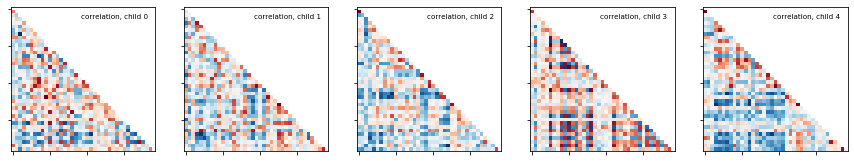

In [2]:
#download full dataset 
full_dataset = datasets.fetch_development_fmri(n_subjects = 122, age_group = 'child')
#create empty array for the children's time series
children = []
for func_file, confound_file in zip(
    full_dataset.func,
    full_dataset.confounds):
    time_series = masker.fit_transform(func_file, confounds = confound_file)
    children.append(time_series)
print('The dataset has {0} children.'.format(len(children)))

children1= children
children2 = children
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(children2)
print('Correlations of children are stacked in an array of shape {0}'.format(correlation_matrices.shape))

#plot lower triangle of first five children in correlation_matrices array
from nilearn import plotting
from matplotlib import pyplot as plt
_, axes=plt.subplots(1, 5, figsize=(15,5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax, title='correlation, child {}'.format(i))

In [12]:
#extracting lower triangle of connectivity matrix-- this method did not work, as the shape was distorted 
#import numpy as np
#vectorized_connectivity = np.empty((122, 881))
#for i, (matrix) in enumerate(zip(correlation_matrices)):
    #indices = np.tril_indices(len(correlation_matrices[i]), k=1)
    #features_flattened = correlation_matrices[indices]
    #vectorized_connectivity[i] = features_flattened[i]
#print(f'# of features per subject: {len(features_flattened)}') 

 
#print(f'the indices of the first matrix: {features_flattened[0]}')



ValueError: could not broadcast input array from shape (39) into shape (881)

In [13]:
vectorized_connectivity = np.empty((122, 1521))
correlation_matrices_lower=np.tril(correlation_matrices)
correlation_matrices_lower.shape
print(correlation_matrices_lower[0])

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.49460792  1.          0.         ...  0.          0.
   0.        ]
 [ 0.10675522  0.01878237  1.         ...  0.          0.
   0.        ]
 ...
 [ 0.1079895   0.05584929  0.02723431 ...  1.          0.
   0.        ]
 [ 0.53490243  0.2440929   0.02234927 ...  0.10548368  1.
   0.        ]
 [ 0.19234932  0.3266371  -0.1595786  ...  0.11670408  0.49004737
   1.        ]]


In [15]:
for i, (matrix) in enumerate(zip(correlation_matrices_lower)):
    vectorized_connectivity[i] =np.ravel(correlation_matrices_lower[i])


  



(122, 1521)
(122, 1)
>r2=-0.106, est=-4.196, cfg={'pca__n_components': 6}
>r2=0.240, est=-4.262, cfg={'pca__n_components': 7}
>r2=-0.108, est=-4.118, cfg={'pca__n_components': 5}
>r2=-0.099, est=-4.246, cfg={'pca__n_components': 11}
>r2=-0.112, est=-3.869, cfg={'pca__n_components': 7}
>r2=0.434, est=-4.064, cfg={'pca__n_components': 11}
>r2=0.307, est=-4.248, cfg={'pca__n_components': 11}
>r2=0.271, est=-3.834, cfg={'pca__n_components': 7}
>r2=0.107, est=-4.123, cfg={'pca__n_components': 11}
>r2=0.152, est=-4.052, cfg={'pca__n_components': 11}
r2: 0.109 std (0.194)


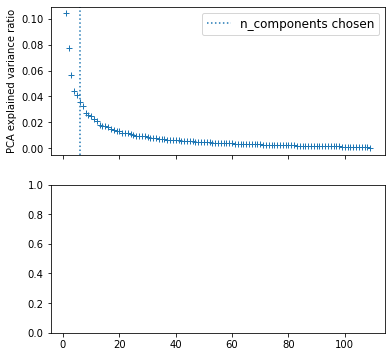

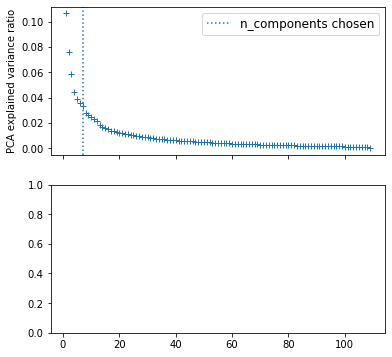

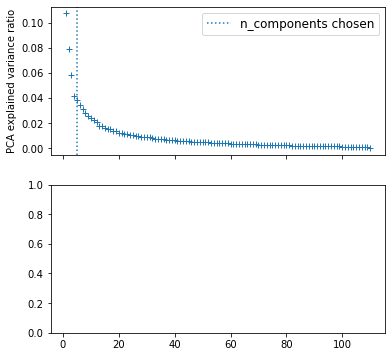

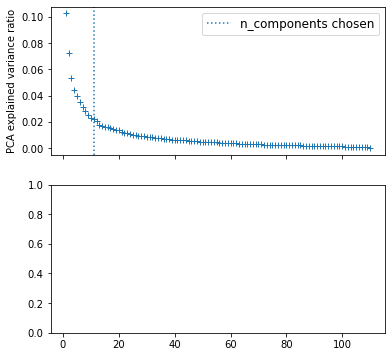

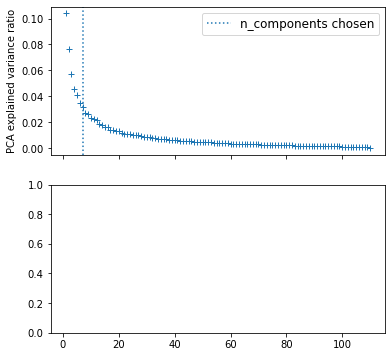

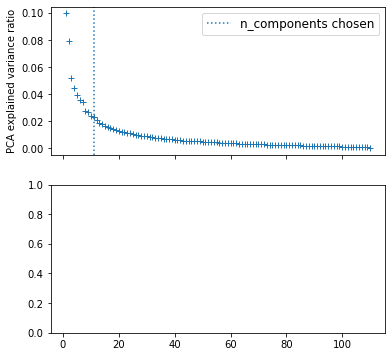

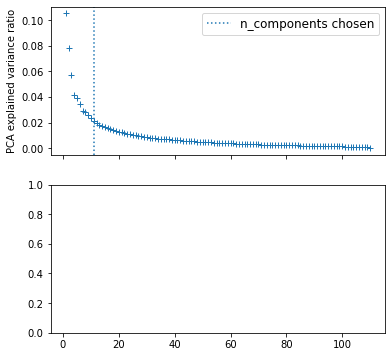

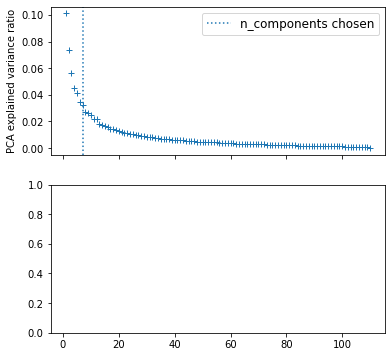

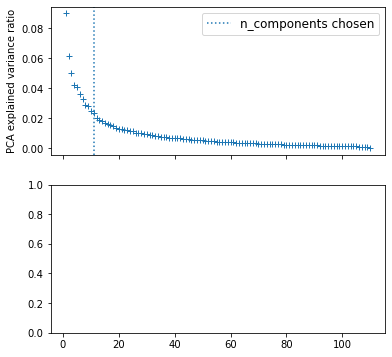

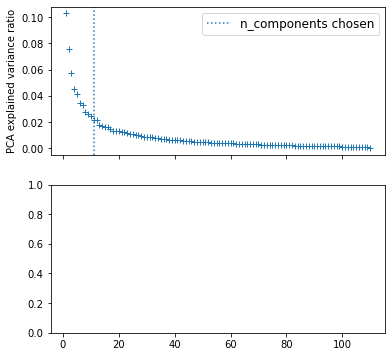

In [21]:
#remove age from phenotypic data 
pheno = full_dataset.phenotypic
age = np.empty((122,1))
for i in range(122):
    age[i] = pheno[i][1]
    
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from numpy import mean, std 


rng = np.random.RandomState(0)
#pcr 
X = vectorized_connectivity
y = age 
print(X.shape)
print(y.shape)


#outer cross validation (10 folds) 
cv_outer = KFold(n_splits = 10, shuffle = True, random_state =1)

outer_results = list()
for train_ix, test_ix in cv_outer.split(X): 
    #split x and y data:
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    #cross-validation procedure
    cv_inner = KFold(n_splits = 5, shuffle = True, random_state =1)

    #define the model
    model_pcr = make_pipeline(StandardScaler(), PCA(), LinearRegression())

    #define space
    space = dict()
    space['pca__n_components'] = [1, 3, 5, 6, 7, 9, 11]
 
    #define search
    search = GridSearchCV(model_pcr, space, scoring='neg_mean_squared_error', cv = cv_inner, refit=True)

    result=search.fit(X_train, y_train)

    #get best performing model fit on the whole training set
    best_model = result.best_estimator_
    #evaluate on the hold out dataset
    yhat = best_model.predict(X_test)
    #evaluate the model
    mse = mean_squared_error(y_test, yhat)
    r2score = r2_score(y_test, yhat)


    # Plot the PCA spectrum
    pca = PCA()
    pca.fit(X_train)

    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
    ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
    ax0.set_ylabel('PCA explained variance ratio')

    ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
    ax0.legend(prop=dict(size=12))


    outer_results.append(r2score)

    #report 
    print('>r2=%.3f, est=%.3f, cfg=%s' % (r2score, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('r2: %.3f std (%.3f)' % (mean(outer_results), std(outer_results)))








In [66]:
model_pcr.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [ ]:
#beginning of the plotting system 
import seaborn as sns 
plt.figure(figsize =(16,6))
heatmap = sns.heatmap(, vmin = -1, vmax = 1, annot = True)
